In [1]:
import numpy as np
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../../../')
from core_thermal_equations import  get_dissipated_heat, NbTi, PhosphorBronze, Kapton

from matplotlib import pyplot as plt
from plot_parameters import FONT, FIG_SIZE, LEGEND_SIZE, FONT_SIZE
plt.rcParams["font.family"] = FONT
plt.rcParams.update({'font.size': FONT_SIZE})
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize

### Simulate Parasitics on thermal conductance test

In [2]:
# See research notebook #3, page 3

# First, let's see the parasitics from the heater wiring
heater_wire_diameter = 110e-6 # [m]
n_hw_wires = 2 # number of wires
hw_area = n_hw_wires * np.pi * (heater_wire_diameter/2)**2  # [m^2] 
hw_length = 1.2 # [m]
heater_material = NbTi(cryogenic=True)

# Let's also calculate the parasitics from the thermometry
# Assuming Lakeshore thermometer CU: https://www.lakeshore.com/packaging/packagescx
# Phosphor-Bronze wire with material properties from 
# https://www.lakeshore.com/products/categories/specification/temperature-products/cryogenic-accessories/cryogenic-wire
# wire dimensions measured and recorded on page 3 of readout notebook 3
therm_wire_diameter = 127e-6 # [m] thermometer wire diameter # measured 180 um but maybe the insulator adds thickness.
n_thermo_wires = 4 
therm_area = n_thermo_wires * np.pi * (therm_wire_diameter/2)**2 # [m^2]
therm_length = 1.0 # [m]
therm_wire_material = PhosphorBronze(cryogenic=True)



Simulate parasitics when wire is connected to 4 K

In [3]:
T0 = 0.250 # K
T1 = 4 # K
#hw_par_power = get_dissipated_heat(T0, T1, heater_material, hw_area, hw_length)
therm_par_power = get_dissipated_heat(T0, T1, therm_wire_material, therm_area, therm_length)

#print("Heater parasitic power: {:.3f} nW".format(hw_par_power*1e9))
print("Thermometry parasitic power: {:.3f} nW".format(therm_par_power*1e9))

Thermometry parasitic power: 142.552 nW


Simulate parasitics when wire is connected to 350 mK

In [4]:
# Assume we have half of the total length of the wire
T0 = 0.250 # K
T1 = 0.350 # K

hw_length_shorter = hw_length/2 # [m]   
therm_length_shorter = hw_length/2 # [m]

hw_par_power = get_dissipated_heat(T0, T1, heater_material, hw_area, hw_length_shorter)
therm_par_power = get_dissipated_heat(T0, T1, therm_wire_material, therm_area, therm_length_shorter)
total_power = hw_par_power +  therm_par_power
power_to_be_measured = 10e-9
print("Heater parasitic power: {:.3f} nW".format(hw_par_power*1e9))
print("Thermometry parasitic power: {:.3f} nW".format(therm_par_power*1e9))
print("Total parasitic power: {:.3f} nW".format(total_power*1e9))
print("Expected percentage of power: {:.3f} %".format(total_power/power_to_be_measured *100) )

Heater parasitic power: 0.008 nW
Thermometry parasitic power: 0.306 nW
Total parasitic power: 0.314 nW
Expected percentage of power: 3.141 %


Simulate parasitics when wire is connected to 250 and T0 is changing (i.e., during the experiment)

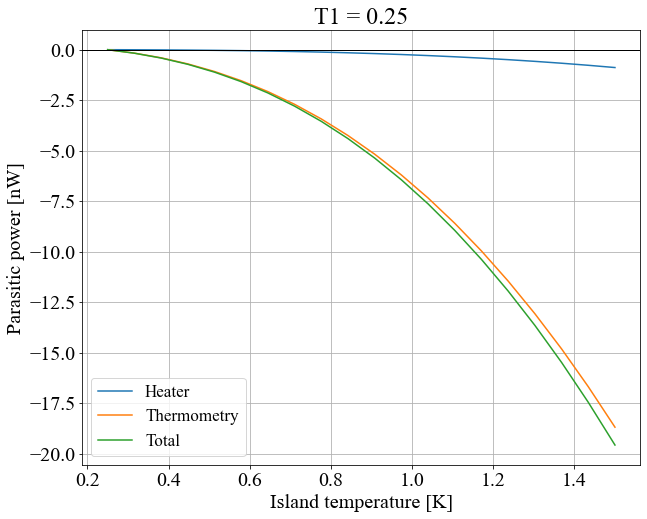

In [5]:
T0s = np.linspace(0.250, 1.5, 20)
T1 = 250e-3 # K

# Initialize arrays to store data
hw_par_powers = np.zeros(len(T0s))
therm_par_powers = np.zeros(len(T0s))

therm_length_apex = 0.65 # [m]
hw_length_apex = 0.65 # [m]

for t, T0_var in enumerate(T0s):
    hw_par_powers[t] = get_dissipated_heat(T0_var, T1, heater_material, \
        hw_area, hw_length_apex)
    therm_par_powers[t] = get_dissipated_heat(T0_var, T1, therm_wire_material, \
        therm_area, therm_length_apex)


plt.figure(1, figsize=FIG_SIZE)
plt.plot(T0s, hw_par_powers*1e9, label="Heater")
plt.plot(T0s, therm_par_powers*1e9, label="Thermometry")
plt.plot(T0s, hw_par_powers*1e9 + therm_par_powers*1e9, label="Total")
plt.xlabel("Island temperature [K]")
plt.ylabel("Parasitic power [nW]")
plt.title("T1 = "+str(T1))
plt.axhline(0, color="black", linestyle="-", linewidth=1)
plt.legend()
plt.grid(True)


Compare to power dissipated by Kapton


<ipython-input-7-e90768d276cb>:42: RuntimeWarning: invalid value encountered in divide
  plt.plot(T0s, total_par_powers/(flex_powers+total_par_powers)*100, color='k' )
<ipython-input-7-e90768d276cb>:49: RuntimeWarning: invalid value encountered in divide
  plt.plot(T0s, total_par_powers/(flex_powers), color='k' )


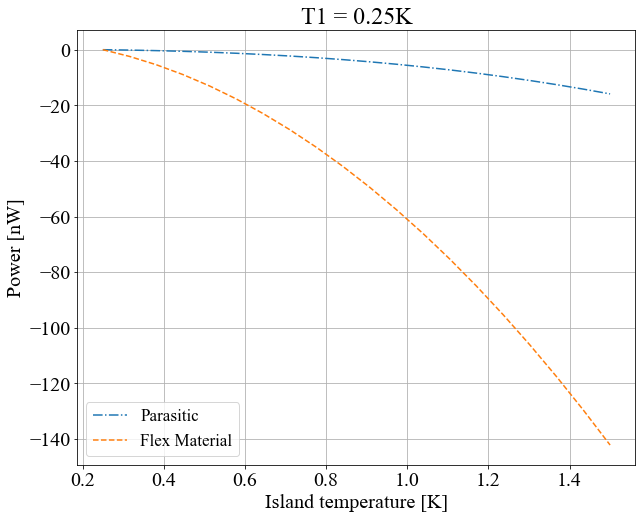

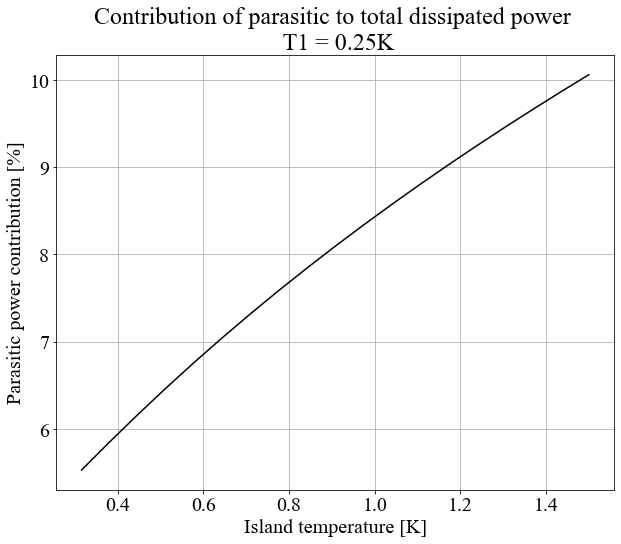

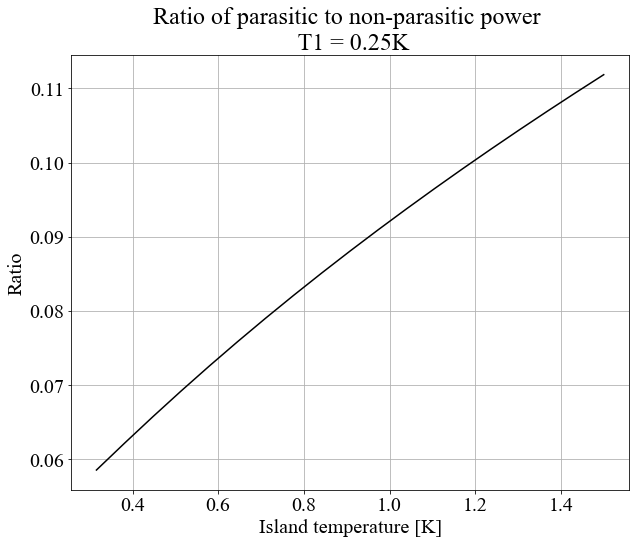

In [7]:
T0s = np.linspace(0.250, 1.5, 20)
T1 = 250e-3 # K

#hw_length_apex = 0. # [m]   
#therm_length_shorter = 0.8 # [m]

# Flex PCB
# geometrical properties
flex_thick =  2 * 12.5e-6 # [m]
flex_length = 25e-3 # m
flex_width = 2 * 10e-3 # m   -- assuming 2 sides
flex_area = flex_thick * flex_width
flex_material = Kapton()

# Initialize arrays to store data
hw_par_powers = np.zeros(len(T0s))
therm_par_powers = np.zeros(len(T0s))
total_par_powers = np.zeros(len(T0s))
flex_powers = np.zeros(len(T0s))

for t, T0_var in enumerate(T0s):
    # Calculate parasitic power
    hw_par_powers[t] = get_dissipated_heat(T0_var, T1, heater_material, \
        hw_area, hw_length_apex)
    therm_par_powers[t] = get_dissipated_heat(T0_var, T1, therm_wire_material, \
        therm_area, therm_length_apex)
    total_par_powers[t] = hw_par_powers[t] + therm_par_powers[t]
    # Calculate power dissipated by flex material
    flex_powers[t] = get_dissipated_heat(T0_var, T1, flex_material, \
        flex_area, flex_length)

plt.figure(1,figsize=FIG_SIZE)
plt.plot(T0s, total_par_powers*1e9, label="Parasitic", linestyle='-.')
plt.plot(T0s, flex_powers*1e9, label="Flex Material", linestyle='--')
plt.xlabel("Island temperature [K]")
plt.ylabel("Power [nW]")
plt.title("T1 = "+str(T1) + "K")
plt.legend()
plt.grid()

plt.figure(2, figsize=FIG_SIZE)
plt.plot(T0s, total_par_powers/(flex_powers+total_par_powers)*100, color='k' )
plt.xlabel("Island temperature [K]")
plt.ylabel("Parasitic power contribution [%]")
plt.title("Contribution of parasitic to total dissipated power \n T1 = "+str(T1) + "K")
plt.grid()

plt.figure(3, figsize=FIG_SIZE)
plt.plot(T0s, total_par_powers/(flex_powers), color='k' )
plt.xlabel("Island temperature [K]")
plt.ylabel("Ratio")
plt.title("Ratio of parasitic to non-parasitic power \n T1 = "+str(T1) + "K")
plt.grid()